In [1]:
import cmath

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import factorized
from scipy.sparse import diags, csc_matrix

In [50]:
def sech(x):
    return 1.0/np.cosh(x)

def apply_boundary_conditions(u, b):
    u[:2] = u[-2:] = 0.0
    b[:1] = b[-1:] = 0.0
    
def second_derivative(f):
    result = np.zeros_like(f)
    result[1:-1] = (f[2:] - 2.0*f[1:-1] + f[:-2])/(dx**2)
    return result

def D2_k2(f):
    return second_derivative(f) - k**2 * f

def L_op(f, F, d2Fdx2):
    return 1j*k*(F*D2_k2(f) - d2Fdx2*f)

def fourth_derivative(f):
    result = np.zeros_like(f)
    result[2:-2] = (f[4:] - 4.0*f[3:-1] + 6.0*f[2:-2] -4.0*f[1:-3] + f[:-4])/(dx**4)
    return result

def calc_vel_RHS():
    # This assumes U0 = 0
    return L_op(b, B0, d2B0dx2) + ooRe*(fourth_derivative(u) - 2*k**2 * second_derivative(u) + k**4 * u)

def calc_mag_RHS():
    # This assumes U0 = 0
    return 1j*k*(B0*u) + ooS * D2_k2(b)

Set up constants

In [53]:
Lx = 10.0
nx = 1001
ooRe = 1e-6
ooS = 1e-5
k = 0.5
T = 1e-4
plot_time = 1e-4

d = Lx/2
dx = (2*d)/(nx-1)

print("dx:", dx)
# print("diffusion limit on dt:", dx**2 / 4)
dt = 0.5 * dx**2 / 4
print("dt:", dt)
print("timesteps:", T/dt)

dx: 0.01
dt: 1.25e-05
timesteps: 8.0


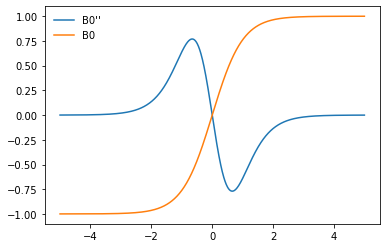

In [54]:
x = np.linspace(-d, d, nx)

U0 = np.zeros_like(x)
dU0dx = np.zeros_like(x)
d2U0dx2 = np.zeros_like(x)

B0 = np.zeros_like(x)
B0 = np.tanh(x)
dB0dx = np.power(sech(x), 2)
d2B0dx2 = -2*np.power(sech(x), 2)*np.tanh(x)

plt.plot(x, d2B0dx2, label='B0\'\'')
# plt.plot(x, second_derivative(B0))

plt.plot(x, B0, label='B0')
# plt.plot(x, U0, label='U0')
plt.legend(frameon=False)
plt.show()

Set up the implicit operator for solving for u

In [55]:
implicit_op = csc_matrix(diags([1/(dx**2), -2/(dx**2) - k**2, 1/(dx**2)], [-1, 0, 1], shape=(nx, nx), dtype=np.complex128))
solve_for_u = factorized(implicit_op)

In [56]:
def plot(axes):
    axes[0,0].plot(x, np.real(u), label='$u$')
    axes[0,1].plot(x, np.imag(b), label='$b$')
    axes[1,0].plot(x, np.real(dudt_curr), label='$G_u$')
    axes[1,1].plot(x, np.imag(dbdt_curr), label='$G_b$')

KeyboardInterrupt: 

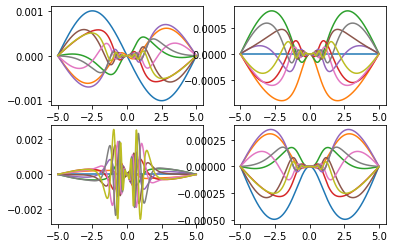

In [59]:
dudt_prev = np.zeros(nx, dtype=np.complex128)
dbdt_prev = np.zeros(nx, dtype=np.complex128)

epsilon = 1e-3

u = epsilon*np.sin(np.linspace(0, 2*np.pi, nx, dtype = np.complex128))
b = epsilon*np.sin(np.linspace(0, np.pi, nx, dtype = np.complex128))

# u = np.zeros(nx, dtype=np.complex128)
# b = np.zeros(nx, dtype=np.complex128)

T = 50
plot_time = 0.1*T

fig, axes = plt.subplots(2, 2)

t = 0
next_plot_time = 0
while t < T:
    if t > next_plot_time:
        print(t)
        plot(axes)
        next_plot_time += plot_time
    
    dudt_curr = calc_vel_RHS()
    dbdt_curr = calc_mag_RHS()

    b += dt/2*(3*dbdt_curr - dbdt_prev)
    u_ab_rhs = D2_k2(u) + dt/2*(3*dudt_curr - dudt_prev)
#     plt.plot(x, np.abs(u_ab_rhs))
    u = solve_for_u(u_ab_rhs)
    
    dudt_prev[:] = dudt_curr[:]
    dbdt_prev[:] = dbdt_curr[:]
    
    t += dt
    
axes[0,0].set_ylabel("$u$")
axes[0,1].set_ylabel("$b$")
axes[1,0].set_ylabel("$G_u$")
axes[1,1].set_ylabel("$G_b$")


plt.tight_layout()
plt.show()

plt.plot